# ML supervisé pour les timeseries

Dans ce premier notebook on va créer un modèle simple de la forme  $ Y_t = f(Y_{t-1}, Y_{t-2}, Y_{t-3}) $

Charger le dataset 'univariate_time_series.csv'. On utilisera les argument index_col et parse_dates

In [52]:
import pandas as pd

data = pd.read_csv("donnees/univariate_time_series.csv",parse_dates=["timestamp"],index_col=["timestamp"])

Afficher la time series

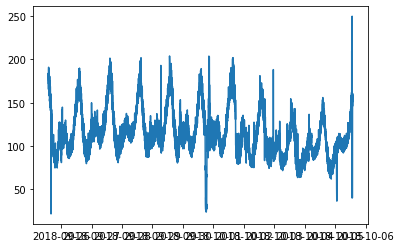

In [9]:
import matplotlib.pyplot as plt

plt.plot(data)

Avec la méthode shift de pandas créer les colonnes correspondants à $Y_{t-1}, Y_{t-2}, Y_{t-3}$ avec la méthode shift de pandas

In [53]:
data["yt-1"]=data["count"].shift(periods=1)
data["yt-2"]=data["count"].shift(periods=2)
data["yt-3"]=data["count"].shift(periods=3)

On va normaliser les données de la série temporelle avec le scaler MinMaxScaler. Importer le MinMaxScaler du module preprocessing de sklearn et normaliser les données du dataframe

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data[["yt-1","yt-2","yt-3","count"]])
data_scaled = scaler.transform(data[["yt-1","yt-2","yt-3","count"]])

data_scaled


array([[       nan,        nan,        nan, 0.70469147],
       [0.70469147,        nan,        nan, 0.67737012],
       [0.67737012, 0.70469147,        nan, 0.71098496],
       ...,
       [0.57018837, 0.56917371, 0.5617781 , 0.57916282],
       [0.57916282, 0.57018837, 0.56917371, 0.56475209],
       [0.56475209, 0.57916282, 0.57018837, 0.54794467]])

Le scaler retourne-t-il un dataframe ? Sinon le recréer à partir des données normalisées

In [55]:
data_scaled = pd.DataFrame(data_scaled,columns=["yt-1","yt-2","yt-3","count"])
data_scaled.index = data.index

data_scaled = data_scaled.dropna()


Sauvegarder le dataframe dans un fichier "time_series_preprocessed.csv"

In [56]:
data_scaled.to_csv("donnees/time_series_preprocessed.csv")
data_scaled

,yt-1,yt-2,yt-3,count
timestamp,,,,
2018-09-25 14:04:00,0.710985,0.677370,0.704691,0.684223
2018-09-25 14:05:00,0.684223,0.710985,0.677370,0.630302
2018-09-25 14:06:00,0.630302,0.684223,0.710985,0.702067
2018-09-25 14:07:00,0.702067,0.630302,0.684223,0.713543
2018-09-25 14:08:00,0.713543,0.702067,0.630302,0.708300
...,...,...,...,...
2018-10-05 13:54:00,0.561778,0.570468,0.579871,0.569174
2018-10-05 13:55:00,0.569174,0.561778,0.570468,0.570188
2018-10-05 13:56:00,0.570188,0.569174,0.561778,0.579163


Séparer les données en train et test 

In [57]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_scaled, test_size=0.2)

Entrainer une régression linéaire sur les données de train

In [58]:
from sklearn.linear_model import LinearRegression

# Select a linear model
model = LinearRegression()

# Train the model
model.fit(train[["yt-1","yt-2","yt-3"]], train["count"])

LinearRegression()

Avec la méthode score du modèle, afficher le score de train et le score de test

In [77]:
from sklearn.metrics import accuracy_score
import numpy as np

print("Train :")
print(model.score(train[["yt-1","yt-2","yt-3"]],train["count"]))

print("Test :")
print(model.score(test[["yt-1","yt-2","yt-3"]],test["count"]))

Train :
0.9386186078238171
Test :
0.9372811090415232


Afficher les coefficients du modèle

In [78]:
print(model.coef_)

[0.54163023 0.21584516 0.22238733]


On va maintenant voir comment faire pour faire des prédiction à plusieurs time step. L'idée est similaire à avant. On va simplement shift du nombre de time step qu'on veut prédire. 

Réentraîner une regression linéaire

A la place d'une régression linéaire on va utiliser un arbre de décision. Importer le modèle DecisionTreeRegressor